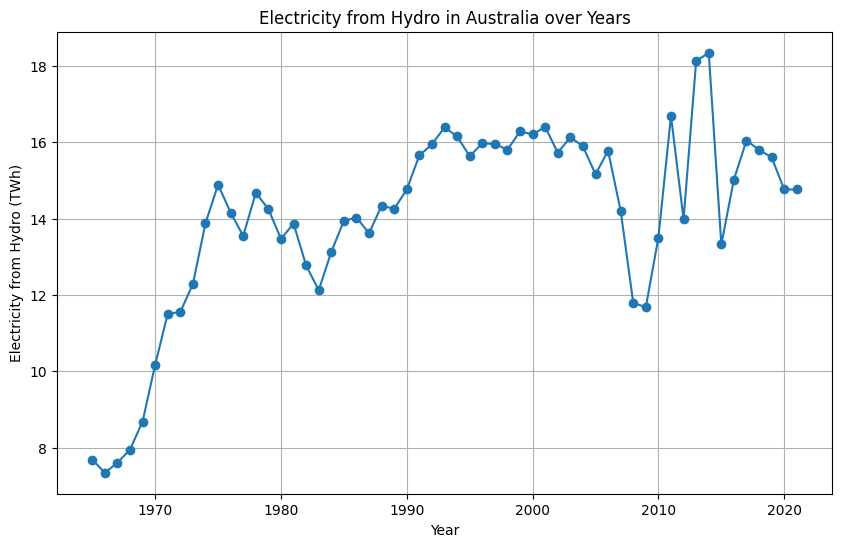

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

def LinearRegressionFit(X, y):
    n = len(X)
    x_mean = sum(X) / n
    y_mean = sum(y) / n

    numerator = sum((X[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = sum((X[i] - x_mean) ** 2 for i in range(n))

    b1 = numerator / denominator
    b0 = y_mean - b1 * x_mean

    return b0, b1

# Load your historical data up to 2020
data = pd.read_csv('~/Documents/forecastRenewableProd/renewable.csv')

# Handle missing values
data = data.fillna(0)

# Filter data for Australia
australia_data = data[data['Entity'] == 'Australia']

# Line plot for Electricity from Hydro for Australia over Years
plt.figure(figsize=(10, 6))
plt.plot(australia_data['Year'], australia_data['Electricity from hydro (TWh)'], marker='o', linestyle='-')
plt.title('Electricity from Hydro in Australia over Years')
plt.xlabel('Year')
plt.ylabel('Electricity from Hydro (TWh)')
plt.grid(True)
plt.show()



In [2]:
data = pd.read_csv('~/Documents/forecastRenewableProd/renewable.csv')

# Handle missing value
data = data.fillna(0)

# grouping the data by the 'Entity' column
grouped_data = data.groupby('Entity')

# list of feature columns
feature_columns = ['Electricity from hydro (TWh)', 'Electricity from wind (TWh)', 'Electricity from solar (TWh)', 'Other renewables including bioenergy (TWh)', 'Total (TWh)']

# Create a new DataFrame for the years 2025 to 2050
years = list(range(2025, 2051))

# Initializing an empty list to store all predictions
all_predictions = []

# Iterate through each entity group
for entity, entity_data in grouped_data:
    predictions = {'Entity': entity}
    
    for column in feature_columns:
        X = entity_data['Year'].tolist()
        y = entity_data[column].tolist()
        
        if (entity_data['Year'] == 2020).any():
            estimated_value_last_year = entity_data[entity_data['Year'] == 2020][column].values[0]
        else:
            estimated_value_last_year = 0  
        # Calculate b0 and b1 for the current entity and column
        b0, b1 = LinearRegressionFit(X, y)
        
        # Make predictions for the current entity and column for the years 2025 to 2050
        column_predictions = []
        for year in years:
            prediction = b0 + b1 * year
            if prediction < 0:
                prediction = 0

            # Append the prediction to the list of predictions for the current column
            column_predictions.append(prediction)
            
            # Update the estimated value for the next year
            estimated_value_last_year = prediction
        
        # Store the predictions for the current column
        predictions[column] = column_predictions
    
    all_predictions.append(predictions)



In [3]:
# Connect to SQLite database
conn = sqlite3.connect('renewable_predictions_test.db')

# Create the 'predictions' table if it doesn't exist
create_table_query = '''
CREATE TABLE IF NOT EXISTS predictions (
    Entity TEXT,
    Year INTEGER,
    "Electricity from hydro (TWh)" REAL,
    "Electricity from wind (TWh)" REAL,
    "Electricity from solar (TWh)" REAL,
    "Other renewables including bioenergy (TWh)" REAL,
    "Total (TWh)" REAL
);
'''
conn.execute(create_table_query)

# Commit the table creation
conn.commit()

# Iterate through predictions and prepare data for DataFrame and database insertion
for prediction_data in all_predictions:
    entity = prediction_data['Entity']
    for year, hydro_list, wind_list, solar_list, bioenergy_list, total_list in zip(
        years,
        prediction_data['Electricity from hydro (TWh)'],
        prediction_data['Electricity from wind (TWh)'],
        prediction_data['Electricity from solar (TWh)'],
        prediction_data['Other renewables including bioenergy (TWh)'],
        prediction_data['Total (TWh)'],
    ):
        # Check if the combination of 'Year' and 'Entity' exists in the database
        query = f"SELECT * FROM predictions WHERE Year={year} AND Entity='{entity.replace(chr(39), chr(39)*2)}'"
        existing_data = pd.read_sql_query(query, conn)
        
        # If no existing data found, append to the lists for DataFrame and insert into the database
        if existing_data.empty:
            entity.append(entity)
            years.append(year)
            hydro_list.append(hydro)
            wind_list.append(wind)
            solar_list.append(solar)
            bioenergy_list.append(bioenergy)
            total_list.append(total)

            # Insert new records into the database
            new_record = {
                'Entity': entity,
                'Year': year,
                'Electricity from hydro (TWh)': hydro,
                'Electricity from wind (TWh)': wind,
                'Electricity from solar (TWh)': solar,
                'Other renewables including bioenergy (TWh)': bioenergy,
                'Total (TWh)': total
            }
            pd.DataFrame([new_record]).to_sql('predictions', conn, if_exists='append', index=False)
            print(new_record)

# Commit changes and close the database connection
conn.commit()
conn.close()

# Create the DataFrame after filtering out duplicates
output_df = pd.DataFrame({
    'Entity': entity,
    'Year': years,
    'Electricity from hydro (TWh)': hydro_list,
    'Electricity from wind (TWh)': wind_list,
    'Electricity from solar (TWh)': solar_list,
    'Other renewables including bioenergy (TWh)': bioenergy_list,
    'Total (TWh)': total_list,
})



In [4]:
import pandas as pd
import sqlite3

# Connect to the SQLite database 'renewable_predictions_test.db'
conn = sqlite3.connect('renewable_predictions_test.db')

# Query to select all data from the 'predictions' table
query = "SELECT * FROM predictions"

# Read data from the database into a DataFrame
data_from_db = pd.read_sql_query(query, conn)

# Close the connection to the database
conn.close()

# Display the fetched data using Pandas DataFrame
print(data_from_db)


                   Entity  Year  Electricity from hydro (TWh)  \
0             Afghanistan  2025                      1.007499   
1             Afghanistan  2026                      1.027357   
2             Afghanistan  2027                      1.047216   
3             Afghanistan  2028                      1.067075   
4             Afghanistan  2029                      1.086934   
...                   ...   ...                           ...   
6521  Western Africa (BP)  2046                     28.808868   
6522  Western Africa (BP)  2047                     29.127115   
6523  Western Africa (BP)  2048                     29.445363   
6524  Western Africa (BP)  2049                     29.763610   
6525  Western Africa (BP)  2050                     30.081858   

      Electricity from wind (TWh)  Electricity from solar (TWh)  \
0                        0.000000                      0.068261   
1                        0.000000                      0.071621   
2                 

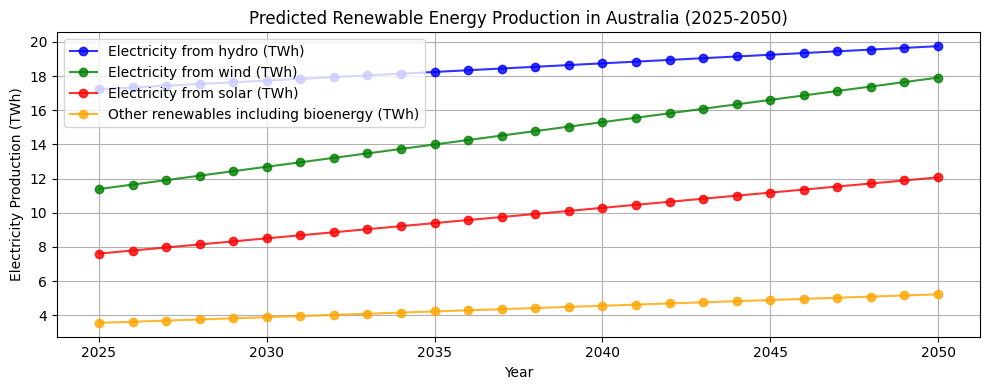

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

conn = sqlite3.connect('renewable_predictions_test.db')

query = "SELECT * FROM predictions WHERE Entity='Australia'"

australia_predictions = pd.read_sql_query(query, conn)

conn.close()

feature_columns = ['Electricity from hydro (TWh)', 'Electricity from wind (TWh)', 'Electricity from solar (TWh)', 'Other renewables including bioenergy (TWh)', 'Total (TWh)']


plt.figure(figsize=(10, 4))  # Adjust the size here

# Define colors and line styles
colors = ['blue', 'green', 'red', 'orange']
# line_styles = ['-', '--', '-.', ':']

# Plot each feature column separately (excluding 'Total (TWh)')
for i, column in enumerate(feature_columns):
    if column != 'Entity' and column != 'Year' and column != 'Total (TWh)':
        plt.plot(
            australia_predictions['Year'],
            australia_predictions[column],
            label=column,
            color=colors[i % len(colors)],
            # linestyle=line_styles[i % len(line_styles)],
            marker='o',  # Add markers to data points
            alpha=0.8  # Set transparency
        )

plt.title('Predicted Renewable Energy Production in Australia (2025-2050)')
plt.xlabel('Year')
plt.ylabel('Electricity Production (TWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()